In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import types
import copy

import h5py
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn.functional as F
import torch_geometric
import tqdm
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree


class MerfishDataset(torch_geometric.data.InMemoryDataset):
    def __init__(
        self,
        root,
        n_neighbors=3,
        train=True,
        log_transform=True,
        neighbor_celltypes=False,
        radius=None,
        non_response_genes_file="/home/roko/spatial/spatial/"
        "non_response_blank_removed.txt",
        splits=0,
    ):
        super().__init__(root)

        # non-response genes (columns) in MERFISH
        with open(non_response_genes_file, "r", encoding="utf8") as genes_file:
            self.features = [int(x) for x in genes_file.read().split(",")]
            genes_file.close()

        # response genes (columns in MERFISH)
        self.response_genes = list(set(range(155)) - set(self.features))

        data_list = self.construct_graphs(
            n_neighbors, train, log_transform, neighbor_celltypes, radius, splits
        )

        with h5py.File(self.merfish_hdf5, "r") as h5f:
            self.gene_names = h5f["gene_names"][:][~self.bad_genes].astype("U")

        self.data, self.slices = self.collate(data_list)

    # from https://datadryad.org/stash/dataset/doi:10.5061/dryad.8t8s248
    url = "https://datadryad.org/stash/downloads/file_stream/67671"

    behavior_types = [
        "Naive",
        "Parenting",
        "Virgin Parenting",
        "Aggression to pup",
        "Aggression to adult",
        "Mating",
    ]
    behavior_lookup = {x: i for (i, x) in enumerate(behavior_types)}
    cell_types = [
        "Ambiguous",
        "Astrocyte",
        "Endothelial 1",
        "Endothelial 2",
        "Endothelial 3",
        "Ependymal",
        "Excitatory",
        "Inhibitory",
        "Microglia",
        "OD Immature 1",
        "OD Immature 2",
        "OD Mature 1",
        "OD Mature 2",
        "OD Mature 3",
        "OD Mature 4",
        "Pericytes",
    ]
    celltype_lookup = {x: i for (i, x) in enumerate(cell_types)}

    bad_genes = np.zeros(161, dtype=bool)
    bad_genes[[12, 13, 14, 15, 16, 144]] = True

    @property
    def raw_file_names(self):
        return ["merfish.csv", "merfish.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "merfish.csv")

    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "merfish.hdf5")

    def download(self):
        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)

        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(dataframe.keys()[:9], dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(dataframe[colnm]))

            expression = np.array(dataframe[dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)
            
    @staticmethod
    def data_transform(data, split_locations, log_transform):
        return torch.log1p(data) if log_transform else data

    @staticmethod
    def calculate_neighborhood(split_locations, radius, n_neighbors):
        # only include self edges if n_neighbors is 0
        if n_neighbors == 0 and radius is None:
            edges = np.concatenate(
                [
                    np.c_[np.array([i]), np.array([i])]
                    for i in range(split_locations.shape[0])
                ],
                axis=0,
            )

        else:

            if radius is None:
                nbrs = neighbors.NearestNeighbors(
                    n_neighbors=n_neighbors + 1, algorithm="ball_tree"
                )
                nbrs.fit(split_locations)
                _, kneighbors = nbrs.kneighbors(split_locations)
                edges = np.concatenate(
                    [
                        np.c_[kneighbors[:, 0], kneighbors[:, i]]
                        for i in range(n_neighbors + 1)
                    ],
                    axis=0,
                )

            else:

                tree = cKDTree(split_locations)
                kneighbors = tree.query_ball_point(
                    split_locations, r=radius, return_sorted=False
                )
                edges = np.concatenate(
                    [
                        np.c_[
                            np.repeat(i, len(kneighbors[i])),
                            list(kneighbors[i]),
                        ]
                        for i in range(len(kneighbors))
                    ],
                    axis=0,
                )

        return torch.tensor(edges, dtype=torch.long).T

    # pylint: disable=too-many-statements
    def construct_graph(
        self,
        data,
        anid,
        breg,
        n_neighbors,
        log_transform,
        neighbor_celltypes,
        radius,
        splits=0,
    ):
        def get_neighbors(edges, x_shape):
            return [edges[:, edges[0] == i][1] for i in range(x_shape)]

        def get_celltype_simplex(cell_behavior_tensor, neighbors_tensor):
            num_classes = cell_behavior_tensor.max() + 1
            return torch.cat(
                [
                    (
                        torch.mean(
                            1.0
                            * F.one_hot(
                                cell_behavior_tensor.index_select(0, neighbors),
                                num_classes=num_classes,
                            ),
                            dim=0,
                        )
                    ).unsqueeze(0)
                    for neighbors in neighbors_tensor
                ],
                dim=0,
            )

        # get subset of cells in this slice
        good = (data.anids == anid) & (data.bregs == breg)
        
        
        # index 0 is behavior, index 1 is celltype, # last 2 are the location. Will update it
        # to be last 3 in the case that bregma is included in location.
        data_for_this_slice = np.concatenate((
            data.behavior[good].reshape(-1,1), 
            data.celltypes[good].reshape(-1,1), 
            data.expression[good], 
            data.locations[good]
        ), axis=1)
        
        
        # graph splitting
        graph_splits = [data_for_this_slice]
        new_splits = []
        while splits != 0:
            for graph in graph_splits:
                locations = graph[:, -2:].astype(np.float32)
                x_split = np.median(locations, 0)[0].astype(np.float32)
                x_0 = graph[locations[:, 0] < x_split]
                x_1 = graph[locations[:, 0] >= x_split]
                x_0_locations = x_0[:, -2:].astype(np.float32)
                x_1_locations = x_1[:, -2:].astype(np.float32)
                y_split_x_0 = np.median(x_0_locations, 0)[1].astype(np.float32)
                y_split_x_1 = np.median(x_1_locations, 0)[1].astype(np.float32)
                x_00 = x_0[x_0_locations[:, 1] < y_split_x_0]
                x_01 = x_0[x_0_locations[:, 1] >= y_split_x_0]
                x_10 = x_1[x_1_locations[:, 1] < y_split_x_1]
                x_11 = x_1[x_1_locations[:, 1] >= y_split_x_1]
                new_splits += [x_00, x_01, x_10, x_11]
            graph_splits = new_splits
            new_splits = []
            splits -= 1

        data_splits = []

        for split in graph_splits:
            
            split_locations = split[:, -2:].astype("float")
            
            edges = self.calculate_neighborhood(split_locations, radius, n_neighbors)

            # remove gene 144.  which is bad.  for some reason.
            subexpression = split[:, 2:-2]
            subexpression = subexpression[:, ~self.bad_genes]

            # get behavior ids
            behavior_ids = np.array(
                [self.behavior_lookup[x] for x in split[:, 0]]
            )
            celltype_ids = np.array(
                [self.celltype_lookup[x] for x in split[:, 1]]
            )
            labelinfo = np.c_[behavior_ids, celltype_ids]

            # make it into a torch geometric data object, add it to the list!

            # if we want to first log transform the data, we do it here
            # make this one return statement only changing x
            predictors_x = torch.tensor(subexpression.astype(np.float32))
            if neighbor_celltypes:
                test_simplex = get_celltype_simplex(
                    torch.tensor(labelinfo[:, 1]),
                    get_neighbors(edges, predictors_x.shape[0]),
                )
                predictors_x = torch.cat((predictors_x, test_simplex), dim=1)
            predictors_x = self.data_transform(predictors_x, split_locations, log_transform)

            data_splits.append(
                torch_geometric.data.Data(
                    x=predictors_x,
                    edge_index=edges,
                    pos=torch.tensor(split_locations),
                    y=torch.tensor(labelinfo),
                    bregma=breg,
                    anid=anid,
                )
            )

        return data_splits

    def construct_graphs(
        self,
        n_neighbors,
        train,
        log_transform=True,
        neighbor_celltypes=False,
        radius=None,
        splits=0,
    ):
        # load hdf5
        with h5py.File(self.merfish_hdf5, "r") as h5f:
            # pylint: disable=no-member

            data = types.SimpleNamespace(
                anids=h5f["Animal_ID"][:],
                bregs=h5f["Bregma"][:],
                expression=h5f["expression"][:],
                locations=np.c_[h5f["Centroid_X"][:], h5f["Centroid_Y"][:]],
                behavior=h5f["Behavior"][:].astype("U"),
                celltypes=h5f["Cell_class"][:].astype("U"),
            )

            # see if you can update data locations AFTER data was created
            # create a deepcopy and then split the locations

            # get the (animal_id,bregma) pairs that define a unique slice
            unique_slices = np.unique(np.c_[data.anids, data.bregs], axis=0)

            # are we looking at train or test sets?
            # the number for filtering represents animal id
            unique_slices = (
                unique_slices[unique_slices[:, 0] <= 30]
                if train
                else unique_slices[unique_slices[:, 0] > 30]
            )

            # store all the slices in this list...
            data_list = []

            for anid, breg in tqdm.tqdm(unique_slices):
                data_list.append(
                    self.construct_graph(
                        data,
                        anid,
                        breg,
                        n_neighbors,
                        log_transform,
                        neighbor_celltypes,
                        radius,
                        splits=splits,
                    )
                )

            return sum(data_list, [])


class FilteredMerfishDataset(MerfishDataset):
    def __init__(
        self,
        root,
        n_neighbors=3,
        train=True,
        log_transform=True,
        neighbor_celltypes=False,
        radius=None,
        non_response_genes_file="/home/roko/spatial/spatial/"
        "non_response_blank_removed.txt",
        animals=None,
        bregmas=None,
        sexes=None,
        behaviors=None,
        test_animal=None,
        full_animal_holdout=False,
        splits=0,
    ):
        self.root = root
        self.animals = animals
        self.bregmas = bregmas
        self.sexes = sexes
        self.behaviors = behaviors
        self.test_animal = test_animal
        self.full_animal_holdout = full_animal_holdout
        original_csv_file = super().merfish_csv
        new_df = pd.read_csv(original_csv_file)
        # print(f"Original Data {new_df.shape}")
        if self.sexes is not None:
            new_df = new_df[new_df["Animal_sex"].isin(self.sexes)]
        if self.behaviors is not None:
            new_df = new_df[new_df["Behavior"].isin(self.behaviors)]
        if self.animals is not None:
            new_df = new_df[new_df["Animal_ID"].isin(self.animals)]
        if self.bregmas is not None:
            new_df = new_df[new_df["Bregma"].isin(self.bregmas)]
        if new_df.shape[0] == 0:
            raise ValueError("Dataframe has no rows. Cannot build graph.")
        new_df.to_csv(str(self.root) + "/raw/merfish_messi.csv", index=False)
        print(f"Filtered Data {new_df.shape}")
        # print("Filtered csv file created!")
        MerfishDataset.download(self)
        super().__init__(
            root,
            n_neighbors=n_neighbors,
            train=train,
            log_transform=log_transform,
            neighbor_celltypes=neighbor_celltypes,
            non_response_genes_file=non_response_genes_file,
            radius=radius,
            splits=splits,
        )
        # print("Filtered hdf5 file created!")

    #     @property
    #     def raw_file_names(self):
    #         return ["merfish_messi.csv", "merfish_messi.hdf5"]

    # THIS LINE WAS EDITED TO SHOW NEW FILE
    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "merfish_messi.csv")

    # THIS LINE WAS EDITED TO SHOW NEW FILE
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "merfish_messi.hdf5")

    def construct_graphs(
        self,
        n_neighbors,
        train,
        log_transform=True,
        neighbor_celltypes=False,
        radius=None,
        splits=0,
    ):

        # load hdf5
        with h5py.File(self.merfish_hdf5, "r") as h5f:
            # pylint: disable=no-member
            data = types.SimpleNamespace(
                anids=h5f["Animal_ID"][:],
                bregs=h5f["Bregma"][:],
                expression=h5f["expression"][:],
                locations=np.c_[h5f["Centroid_X"][:], h5f["Centroid_Y"][:]],
                behavior=h5f["Behavior"][:].astype("U"),
                celltypes=h5f["Cell_class"][:].astype("U"),
            )

        anid_to_bregma_count = {
            1: 12,
            2: 12,
            3: 6,
            4: 5,
            5: 6,
            6: 6,
            7: 12,
            8: 6,
            9: 6,
            10: 6,
            11: 6,
            12: 4,
            13: 4,
            14: 4,
            15: 4,
            16: 4,
            17: 4,
            18: 4,
            19: 4,
            20: 4,
            21: 4,
            22: 4,
            23: 4,
            24: 4,
            25: 4,
            26: 4,
            27: 2,
            28: 4,
            29: 4,
            30: 4,
        }

        # get the (animal_id,bregma) pairs that define a unique slice
        unique_slices = np.unique(np.c_[data.anids, data.bregs], axis=0)

        # are we looking at train or test sets?

        # if we want a specific animals
        if self.test_animal is not None:

            # we need to find which of the slices
            sorted_anids = np.sort(np.unique(data.anids))
            slices_before_test_anid = 0
            for anid in sorted_anids:
                if anid != self.test_animal:
                    slices_before_test_anid += anid_to_bregma_count[anid]
                else:
                    break

            mask_train = np.ones(unique_slices.shape[0], dtype=bool)
            mask_train[
                slices_before_test_anid : (
                    slices_before_test_anid + anid_to_bregma_count[self.test_animal]
                )
            ] = 0
            unique_slices = (
                unique_slices[(1 - mask_train).astype("bool")]
                if not train
                else unique_slices[mask_train]
            )

        elif self.full_animal_holdout and (
            len(self.animals) > 1 or np.unique(unique_slices[:, 0]) > 1
        ):
            print(f"BEFORE: {unique_slices}")
            min_animal = anid_to_bregma_count[np.min(data.anids)]
            unique_slices = (
                unique_slices[min_animal:] if train else unique_slices[:min_animal]
            )
            print(f"AFTER: {unique_slices}")

        else:
            num_slices = len(unique_slices)
            min_holdout = max(1, round((1 / 7) * num_slices))
            unique_slices = (
                unique_slices[: (num_slices - min_holdout)]
                if train
                else unique_slices[(num_slices - min_holdout) :]
            )

        # store all the slices in this list...
        data_list = []
        for anid, breg in unique_slices:
            data_list.append(
                self.construct_graph(
                    data,
                    anid,
                    breg,
                    n_neighbors,
                    log_transform,
                    neighbor_celltypes,
                    radius,
                    splits,
                )
            )

        return sum(data_list, [])


In [3]:
class SyntheticDataset0(MerfishDataset):
    
    @property
    def raw_file_names(self):
        return ["synth0.csv", "synth0.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth0.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth0.hdf5")
    
    @staticmethod
    def _gate(edges, data, i):
        neighboring_gene1_expr = torch.sum(data[edges[:, edges[0] == i][1], 20])
        return neighboring_gene1_expr.item() * (neighboring_gene1_expr > 1).item()        

    def download(self):
        
        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 5, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[["Animal_ID", "Bregma"]]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[(dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)]
            edges = self.calculate_neighborhood(
                torch.tensor(sub_dataframe.to_numpy()[:, 5:7].astype("float64")), radius=true_radius, n_neighbors=None
            ).to("cuda:0")
            sub_dataframe = sub_dataframe.to_numpy()
            sub_dataframe[:, 9:] = (
                torch.distributions.negative_binomial.NegativeBinomial(1, 0.5).sample(
                    sub_dataframe[:, 9:].shape
                )
                / cell_volume
            )
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to("cuda:0")
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, x=expressions: self._gate(edges, expressions, i)
            )
            sub_dataframe[:, 9:][:, 0] = output.numpy()
            new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))

        new_dataframe = new_dataframe.astype({"Animal_ID": 'int64', "Bregma": "float64", "Centroid_X": "float64", "Centroid_Y": "float64"})
        
        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))
            
            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression, dtype='float64')

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)
            

In [4]:
class SyntheticDataset1(MerfishDataset):
    
    @property
    def raw_file_names(self):
        return ["synth1.csv", "synth1.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth1.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth1.hdf5")
    
    @staticmethod
    def _gate(edges, data, i):
        neighboring_gene1_expr = torch.sum(data[edges[:, edges[0] == i][1], 20])
        return neighboring_gene1_expr.item() * (neighboring_gene1_expr > 1).item()
            
    def download(self):
        
        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 5, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[["Animal_ID", "Bregma"]]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[(dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)]
            edges = self.calculate_neighborhood(
                torch.tensor(sub_dataframe.to_numpy()[:, 5:7].astype("float64")), radius=true_radius, n_neighbors=None
            ).to("cuda:0")
            sub_dataframe = sub_dataframe.to_numpy()
            sub_dataframe[:, 9:] = (
                torch.distributions.exponential.Exponential(10).rsample(
                    sub_dataframe[:, 9:].shape
                )
            )
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to("cuda:0")
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, x=expressions: self._gate(edges, expressions, i)
            )
            sub_dataframe[:, 9:][:, 0] += output.numpy()
            new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))

        new_dataframe = new_dataframe.astype({"Animal_ID": 'int64', "Bregma": "float64", "Centroid_X": "float64", "Centroid_Y": "float64"})
        
        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [4]:
class SyntheticDataset2(MerfishDataset):
    
    @property
    def raw_file_names(self):
        return ["synth2.csv", "synth2.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth2.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth2.hdf5")
    
    @staticmethod
    def _transform(edges, data, i):
        neighboring_gene_expr = (
            torch.mean(data[edges[:, edges[0] == i][1], 1:10])
        ).item()
        return neighboring_gene_expr * (2 ** np.sign(neighboring_gene_expr - torch.mean(data[:, 20]).item()))     
            
    def download(self):
        
        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 5, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[["Animal_ID", "Bregma"]]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[(dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)]
            edges = self.calculate_neighborhood(
                torch.tensor(sub_dataframe.to_numpy()[:, 5:7].astype("float64")), radius=true_radius, n_neighbors=None
            ).to("cuda:0")
            sub_dataframe = sub_dataframe.to_numpy()
            sub_dataframe[:, 9:] = (
                torch.exp(torch.distributions.normal.Normal(0, 1).rsample(
                    sub_dataframe[:, 9:].shape
                ))
            )
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to("cuda:0")
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, x=expressions: self._transform(edges, expressions, i)
            )
            sub_dataframe[:, 9:][:, 0] += output.numpy()
            new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))

        new_dataframe = new_dataframe.astype({"Animal_ID": 'int64', "Bregma": "float64", "Centroid_X": "float64", "Centroid_Y": "float64"})
        
        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [5]:
class SyntheticDataset3(MerfishDataset):
    
    @property
    def raw_file_names(self):
        return ["synth3.csv", "synth3.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth3.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth3.hdf5")
    
    @staticmethod
    def _transform(edges, data, i):
        average_gene1_expr = torch.mean(data[:, 20])
        average_gene2_expr = torch.mean(data[:, 21])
        neighboring_gene1_expr = torch.mean(data[edges[:, edges[0] == i][1], 20])
        neighboring_gene2_expr = torch.mean(data[edges[:, edges[0] == i][1], 21])
        return 2 ** (
            1
            if (torch.sign(neighboring_gene1_expr - average_gene1_expr)
            - torch.sign(neighboring_gene2_expr - average_gene2_expr))
            > 0
            else -1
        )
            
    def download(self):
        
        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 5, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[["Animal_ID", "Bregma"]]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[(dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)]
            edges = self.calculate_neighborhood(
                torch.tensor(sub_dataframe.to_numpy()[:, 5:7].astype("float64")), radius=true_radius, n_neighbors=None
            ).to("cuda:0")
            sub_dataframe = sub_dataframe.to_numpy()
            sub_dataframe[:, 9:] = (
                torch.exp(torch.distributions.normal.Normal(0, 0.25).rsample(
                    sub_dataframe[:, 9:].shape
                ))
            )
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to("cuda:0")
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, x=expressions: self._transform(edges, expressions, i)
            )
            sub_dataframe[:, 9:][:, 0] *= output.numpy()
            new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))

        new_dataframe = new_dataframe.astype({"Animal_ID": 'int64', "Bregma": "float64", "Centroid_X": "float64", "Centroid_Y": "float64"})
        
        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [6]:
class SyntheticDataset4(MerfishDataset):
    
    @property
    def raw_file_names(self):
        return ["synth4.csv", "synth4.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth4.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth4.hdf5")
    
    @staticmethod
    def _weighted_sum(edges, distances, data, i):
        neighboring_gene1_expr = data[edges[:, edges[0] == i][1], 20].to(torch.float64)
        neighboring_gene1_distances = torch.tensor(
            distances[1][distances[0] == i], dtype=torch.float64
        )
        neighboring_gene1_expr = torch.dot(
            neighboring_gene1_expr, 1 / (1 + neighboring_gene1_distances)
        )
        return neighboring_gene1_expr
            
    def download(self):
        
        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        true_radius = 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[["Animal_ID", "Bregma"]]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[(dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)]
            sub_dataframe = sub_dataframe.to_numpy()
            tree = KDTree(torch.tensor(sub_dataframe[:, 5:7].astype("float64")))
            edges, distances = tree.query_radius(
                torch.tensor(sub_dataframe[:, 5:7].astype("float64")), r=true_radius, return_distance=True
            )
            distances = torch.tensor(np.concatenate(
                [
                    np.c_[
                        np.repeat(i, len(distances[i])),
                        list(distances[i]),
                    ]
                    for i in range(len(distances))
                ],
                axis=0,
            ).T).to("cuda:0")
            edges = torch.tensor(np.concatenate(
                [
                    np.c_[
                        np.repeat(i, len(edges[i])),
                        list(edges[i]),
                    ]
                    for i in range(len(edges))
                ],
                axis=0,
            ).T).to("cuda:0")
            sub_dataframe[:, 9:] = (
                torch.distributions.exponential.Exponential(10).rsample(
                    sub_dataframe[:, 9:].shape
                )
            )
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to("cuda:0")
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, x=expressions: self._weighted_sum(edges, distances, expressions, i)
            )
            sub_dataframe[:, 9:][:, 0] = output.numpy()
            new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))

        new_dataframe = new_dataframe.astype({"Animal_ID": 'int64', "Bregma": "float64", "Centroid_X": "float64", "Centroid_Y": "float64"})
        
        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [7]:
class SyntheticDataset5(SyntheticDataset4):
    
    @property
    def raw_file_names(self):
        return ["synth5.csv", "synth5.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth5.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth5.hdf5")
    
    @staticmethod
    def _weight(x):
        return 1 - torch.asinh(5.863 * x) / 5.863

    def _weighted_sum(self, edges, distances, data, i):
        neighboring_gene1_expr = data[edges[:, edges[0] == i][1], 20].to(torch.float64)
        neighboring_gene1_distances = torch.tensor(
            distances[1][distances[0] == i], dtype=torch.float64
        )
        neighboring_gene1_expr = torch.dot(
            neighboring_gene1_expr, self._weight(neighboring_gene1_distances)
        )
        return neighboring_gene1_expr

In [8]:
class SyntheticDataset6(SyntheticDataset4):
    
    @property
    def raw_file_names(self):
        return ["synth6.csv", "synth6.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth6.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth6.hdf5")
    
    @staticmethod
    def _weighted_sum(edges, distances, data, i):
        neighboring_gene1_expr = data[edges[:, edges[0] == i][1], 20].to(torch.float64)
        neighboring_gene1_distances = torch.tensor(
            distances[1][distances[0] == i], dtype=torch.float64
        )
        neighboring_gene1_expr = torch.dot(
            neighboring_gene1_expr, 1 / (1 + neighboring_gene1_distances)
        )
        neighboring_gene1_expr += torch.distributions.half_normal.HalfNormal(0.1).rsample(neighboring_gene1_expr.shape)
        return neighboring_gene1_expr

In [9]:
class SyntheticDataset7(SyntheticDataset4):
    
    @property
    def raw_file_names(self):
        return ["synth7.csv", "synth7.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth7.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth7.hdf5")
    
    @staticmethod
    def _weight(x):
        return 1 - torch.asinh(5.863 * x) / 5.863

    def _weighted_sum(self, edges, distances, data, i):
        neighboring_gene1_expr = data[edges[:, edges[0] == i][1], 1].to(torch.float64)
        neighboring_gene1_distances = torch.tensor(
            distances[1][distances[0] == i], dtype=torch.float64
        )
        neighboring_gene1_expr = torch.dot(
            neighboring_gene1_expr, self._weight(neighboring_gene1_distances)
        )
        neighboring_gene1_expr += torch.distributions.half_normal.HalfNormal(0.1).rsample(neighboring_gene1_expr.shape)
        return neighboring_gene1_expr

In [10]:
class SyntheticDataset8(MerfishDataset):
    
    @property
    def raw_file_names(self):
        return ["synth8.csv", "synth8.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth8.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth8.hdf5")
    
    @staticmethod
    def _gate(edges, data, i):
        neighboring_gene1_expr = torch.sum(data[edges[:, edges[0] == i][1], 20])
        return neighboring_gene1_expr.item() * (neighboring_gene1_expr > 1).item()        

    def download(self):

        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 60, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[["Animal_ID", "Bregma"]]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[(dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)]
            edges = self.calculate_neighborhood(
                torch.tensor(sub_dataframe.to_numpy()[:, 5:7].astype("float64")), radius=true_radius, n_neighbors=None
            ).to("cuda:0")
            sub_dataframe = sub_dataframe.to_numpy()
            sub_dataframe[:, 9:] = (
                torch.distributions.negative_binomial.NegativeBinomial(20, 0.5).sample(
                    sub_dataframe[:, 9:].shape
                )
                / cell_volume
            )
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to("cuda:0")
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, x=expressions: self._gate(edges, expressions, i)
            )
            sub_dataframe[:, 9:][:, 0] = output.numpy()
            new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))

        new_dataframe = new_dataframe.astype({"Animal_ID": 'int64', "Bregma": "float64", "Centroid_X": "float64", "Centroid_Y": "float64"})
        
        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [11]:
class SyntheticDataset9(MerfishDataset):
    
    @property
    def raw_file_names(self):
        return ["synth9.csv", "synth9.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth9.csv")    
    
    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth9.hdf5")
    
    @staticmethod
    def _gate(edges, data, i):
        neighboring_gene1_expr = torch.sum(data[edges[:, edges[0] == i][1], 20])
        return neighboring_gene1_expr.item() * (neighboring_gene1_expr > 1).item()        

    def download(self):

        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 60, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[["Animal_ID", "Bregma"]]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[(dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)]
            edges = self.calculate_neighborhood(
                torch.tensor(sub_dataframe.to_numpy()[:, 5:7].astype("float64")), radius=true_radius, n_neighbors=None
            ).to("cuda:0")
            sub_dataframe = sub_dataframe.to_numpy()
            sub_dataframe[:, 9:] = (
                torch.distributions.negative_binomial.NegativeBinomial(20, 0.5).sample(
                    sub_dataframe[:, 9:].shape
                )
                / cell_volume
            )
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to("cuda:0")
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, x=expressions: self._gate(edges, expressions, i)
            )
            sub_dataframe[:, 9:][:, 0] += output.numpy()
            new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))

        new_dataframe = new_dataframe.astype({"Animal_ID": 'int64', "Bregma": "float64", "Centroid_X": "float64", "Centroid_Y": "float64"})
        
        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(np.float64)
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [5]:
class SyntheticDataset10(MerfishDataset):
    @property
    def raw_file_names(self):
        return ["synth10.csv", "synth10.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synth10.csv")

    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synth10.hdf5")

    @staticmethod
    def _weighted_sum(edges, distances, data, i):
        neighboring_gene1_expr = data[edges[:, edges[0] == i][1], 1].to(torch.float64)
        neighboring_gene1_distances = torch.tensor(
            distances[1][distances[0] == i], dtype=torch.float64
        )
        neighboring_gene1_expr = torch.dot(
            neighboring_gene1_expr, 1 / (1 + neighboring_gene1_distances)
        )
        return neighboring_gene1_expr

    def download(self):

        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 60, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[
            ["Animal_ID", "Bregma"]
        ]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[
                (dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)
            ]
            sub_dataframe = sub_dataframe.to_numpy()
            tree = KDTree(torch.tensor(sub_dataframe[:, 5:7].astype("float64")))
            edges, distances = tree.query_radius(
                torch.tensor(sub_dataframe[:, 5:7].astype("float64")),
                r=true_radius,
                return_distance=True,
            )
            distances = torch.tensor(
                np.concatenate(
                    [
                        np.c_[
                            np.repeat(i, len(distances[i])),
                            list(distances[i]),
                        ]
                        for i in range(len(distances))
                    ],
                    axis=0,
                ).T
            ).to("cuda:0")
            edges = torch.tensor(
                np.concatenate(
                    [
                        np.c_[
                            np.repeat(i, len(edges[i])),
                            list(edges[i]),
                        ]
                        for i in range(len(edges))
                    ],
                    axis=0,
                ).T
            ).to("cuda:0")
            means = torch.distributions.normal.Normal(20, 5).sample((len(sub_dataframe[0, 9:]),))
            sub_dataframe[:, 9:] = (
                torch.distributions.negative_binomial.NegativeBinomial(means, 0.5).sample(
                    (sub_dataframe.shape[0], 1)
                )
                / cell_volume
            ).squeeze()
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to(
                "cuda:0"
            )
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, distances=distances, data=expressions: self._weighted_sum(  # pylint: disable=line-too-long
                    edges, distances, data, i
                )
            )
            sub_dataframe[:, 9:][:, 0] = output.numpy()
            new_dataframe = new_dataframe.append(
                pd.DataFrame(sub_dataframe, columns=preserve_columns)
            )

        new_dataframe = new_dataframe.astype(
            {
                "Animal_ID": "int64",
                "Bregma": "float64",
                "Centroid_X": "float64",
                "Centroid_Y": "float64",
            }
        )

        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(
                np.float64
            )
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [11]:
class SyntheticNonlinear(MerfishDataset):
    @property
    def raw_file_names(self):
        return ["synthNonlinear.csv", "synthNonlinear.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synthNonlinear.csv")

    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synthNonlinear.hdf5")

    @staticmethod
    def _weight(x):
        return 1 - torch.asinh(5.863 * x) / 5.863

    def _weighted_sum(self, edges, distances, data, i):
        neighboring_gene1_expr = data[edges[:, edges[0] == i][1], 1].to(torch.float64)
        neighboring_gene1_distances = torch.tensor(
            distances[1][distances[0] == i], dtype=torch.float64
        )
        neighboring_gene1_expr = torch.dot(
            neighboring_gene1_expr ** 2, self._weight(neighboring_gene1_distances)
        )
        neighboring_gene1_expr += torch.distributions.half_normal.HalfNormal(
            0.1
        ).rsample(neighboring_gene1_expr.shape)
        return neighboring_gene1_expr

    def download(self):

        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        cell_volume, true_radius = 60, 30
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[
            ["Animal_ID", "Bregma"]
        ]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[
                (dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)
            ]
            sub_dataframe = sub_dataframe.to_numpy()
            tree = KDTree(torch.tensor(sub_dataframe[:, 5:7].astype("float64")))
            edges, distances = tree.query_radius(
                torch.tensor(sub_dataframe[:, 5:7].astype("float64")),
                r=true_radius,
                return_distance=True,
            )
            distances = torch.tensor(
                np.concatenate(
                    [
                        np.c_[
                            np.repeat(i, len(distances[i])),
                            list(distances[i]),
                        ]
                        for i in range(len(distances))
                    ],
                    axis=0,
                ).T
            ).to("cuda:0")
            edges = torch.tensor(
                np.concatenate(
                    [
                        np.c_[
                            np.repeat(i, len(edges[i])),
                            list(edges[i]),
                        ]
                        for i in range(len(edges))
                    ],
                    axis=0,
                ).T
            ).to("cuda:0")
            means = torch.distributions.normal.Normal(20, 4).sample((len(sub_dataframe[0, 9:]),))
            sub_dataframe[:, 9:] = (
                torch.distributions.negative_binomial.NegativeBinomial(means, 0.5).sample(
                    (sub_dataframe.shape[0], 1)
                )
                / cell_volume
            ).squeeze()
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to(
                "cuda:0"
            )
            output = torch.arange(len(sub_dataframe), dtype=torch.float64).apply_(
                lambda i, edges=edges, distances=distances, data=expressions: self._weighted_sum(  # pylint: disable=line-too-long
                    edges, distances, data, i
                )
            )
            sub_dataframe[:, 9:][:, 0] = output.numpy()
            new_dataframe = new_dataframe.append(
                pd.DataFrame(sub_dataframe, columns=preserve_columns)
            )

        new_dataframe = new_dataframe.astype(
            {
                "Animal_ID": "int64",
                "Bregma": "float64",
                "Centroid_X": "float64",
                "Centroid_Y": "float64",
            }
        )

        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(
                np.float64
            )
            h5f.create_dataset("expression", data=expression)

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [12]:
class MerfishDataset3D(MerfishDataset):
    
    # pylint: disable=too-many-statements
    def construct_graph(
        self,
        data,
        anid,
        breg,
        n_neighbors,
        log_transform,
        neighbor_celltypes,
        radius,
        splits=0,
    ):
        def get_neighbors(edges, x_shape):
            return [edges[:, edges[0] == i][1] for i in range(x_shape)]

        def get_celltype_simplex(cell_behavior_tensor, neighbors_tensor):
            num_classes = cell_behavior_tensor.max() + 1
            return torch.cat(
                [
                    (
                        torch.mean(
                            1.0
                            * F.one_hot(
                                cell_behavior_tensor.index_select(0, neighbors),
                                num_classes=num_classes,
                            ),
                            dim=0,
                        )
                    ).unsqueeze(0)
                    for neighbors in neighbors_tensor
                ],
                dim=0,
            )

        # get subset of cells in this slice
        good = (data.anids == anid)
        
        
        # index 0 is behavior, index 1 is celltype, # last 2 are the location. Will update it
        # to be last 3 in the case that bregma is included in location.
        data_for_this_slice = np.concatenate((
            data.behavior[good].reshape(-1,1), 
            data.celltypes[good].reshape(-1,1), 
            data.expression[good], 
            data.locations[good],
            data.bregs[good].reshape(-1,1)
        ), axis=1)
        
        
        # graph splitting
        graph_splits = [data_for_this_slice]
        new_splits = []
        while splits != 0:
            for graph in graph_splits:
                locations = graph[:, -3:].astype(np.float32)
                x_split = np.median(locations, 0)[0].astype(np.float32)
                x_0 = graph[locations[:, 0] < x_split]
                x_1 = graph[locations[:, 0] >= x_split]
                x_0_locations = x_0[:, -3:].astype(np.float32)
                x_1_locations = x_1[:, -3:].astype(np.float32)
                y_split_x_0 = np.median(x_0_locations, 0)[1].astype(np.float32)
                y_split_x_1 = np.median(x_1_locations, 0)[1].astype(np.float32)
                x_00 = x_0[x_0_locations[:, 1] < y_split_x_0]
                x_01 = x_0[x_0_locations[:, 1] >= y_split_x_0]
                x_10 = x_1[x_1_locations[:, 1] < y_split_x_1]
                x_11 = x_1[x_1_locations[:, 1] >= y_split_x_1]
                x_00_locations = x_00[:, -3:].astype(np.float32)
                x_01_locations = x_01[:, -3:].astype(np.float32)
                x_10_locations = x_10[:, -3:].astype(np.float32)
                x_11_locations = x_11[:, -3:].astype(np.float32)
                z_split_x_0_y_0 = np.median(x_00_locations, 0)[2].astype(np.float32)
                z_split_x_0_y_1 = np.median(x_01_locations, 0)[2].astype(np.float32)
                z_split_x_1_y_0 = np.median(x_10_locations, 0)[2].astype(np.float32)
                z_split_x_1_y_1 = np.median(x_11_locations, 0)[2].astype(np.float32)
                x_000 = x_00[x_00_locations[:, 2] < z_split_x_0_y_0]
                x_001 = x_00[x_00_locations[:, 2] >= z_split_x_0_y_0]
                x_010 = x_01[x_01_locations[:, 2] < z_split_x_0_y_1]
                x_011 = x_01[x_01_locations[:, 2] >= z_split_x_0_y_1]
                x_100 = x_10[x_10_locations[:, 2] < z_split_x_1_y_0]
                x_101 = x_10[x_10_locations[:, 2] >= z_split_x_1_y_0]
                x_110 = x_11[x_11_locations[:, 2] < z_split_x_1_y_1]
                x_111 = x_11[x_11_locations[:, 2] >= z_split_x_1_y_1]
                new_splits += [x_000, x_001, x_010, x_011, x_100, x_101, x_110, x_111]
            graph_splits = new_splits
            new_splits = []
            splits -= 1

        data_splits = []

        for split in graph_splits:
            
            split_locations = split[:, -3:].astype("float")
            
            edges = self.calculate_neighborhood(split_locations, radius, n_neighbors)

            # remove gene 144.  which is bad.  for some reason.
            subexpression = split[:, 2:-3]
            subexpression = subexpression[:, ~self.bad_genes]

            # get behavior ids
            behavior_ids = np.array(
                [self.behavior_lookup[x] for x in split[:, 0]]
            )
            celltype_ids = np.array(
                [self.celltype_lookup[x] for x in split[:, 1]]
            )
            labelinfo = np.c_[behavior_ids, celltype_ids]

            # make it into a torch geometric data object, add it to the list!

            # if we want to first log transform the data, we do it here
            # make this one return statement only changing x
            predictors_x = torch.tensor(subexpression.astype(np.float32))
            if neighbor_celltypes:
                test_simplex = get_celltype_simplex(
                    torch.tensor(labelinfo[:, 1]),
                    get_neighbors(edges, predictors_x.shape[0]),
                )
                predictors_x = torch.cat((predictors_x, test_simplex), dim=1)
            predictors_x = self.data_transform(predictors_x, split_locations, log_transform)

            data_splits.append(
                torch_geometric.data.Data(
                    x=predictors_x,
                    edge_index=edges,
                    pos=torch.tensor(split_locations),
                    y=torch.tensor(labelinfo),
                    anid=anid,
                )
            )

        return data_splits

In [ ]:
for i in range(-1, 10):
    if i == -1:
        with h5py.File(f"../data/raw/merfish.hdf5", "r") as file:
            print(i, file["expression"][:, 0])
    else:
        with h5py.File(f"../data/raw/synth{i}.hdf5", "r") as file:
            print(i, file["expression"][:, 0])
            if i in [0, 8]:
                print(i, "Zero Inflation: ", np.mean(file["expression"][:, 0] == 0))
                plt.hist(file["expression"][:, 0], label=i)
plt.legend(loc="upper right")

In [3]:
old_train = MerfishDataset('../data', splits = 0, radius = 30)
num_train = len(old_train)
old_test = MerfishDataset('../data', splits = 0, radius = 30, train=False)
num_test = len(old_test)
num_train, num_test

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.48s/it]


(157, 24)

In [ ]:
test0 = SyntheticDataset0('../data', splits = 0, radius = 0)

In [9]:
test1 = SyntheticDataset1('../data', splits = 0, radius = 0)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 157/157 [04:22<00:00,  1.67s/it]


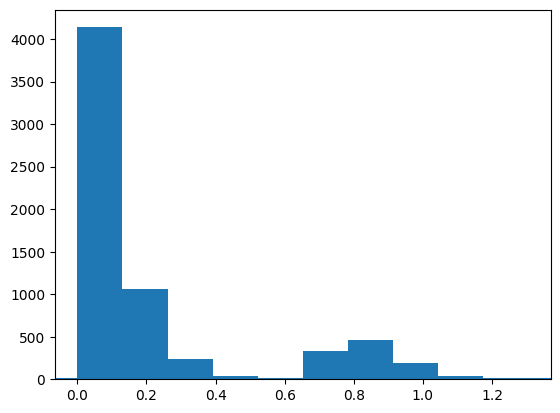

In [11]:
plt.hist(test1[0].x[:, 0])

In [16]:
test2 = SyntheticDataset2('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1936298190.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

In [17]:
test3 = SyntheticDataset3('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3297085001.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_

In [18]:
test4 = SyntheticDataset4('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/3161682461.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:25<00:00,  1.31s/it]


In [19]:
test5 = SyntheticDataset5('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

/tmp/ipykernel_1403745/34757747.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:24<00:00,  1.30s/it]


In [20]:
test6 = SyntheticDataset6('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/1807445631.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:25<00:00,  1.31s/it]


In [21]:
test7 = SyntheticDataset7('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/tmp/ipykernel_1403745/2870224824.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighboring_gene1_distances = torch.tensor(
/tmp/ipykernel_1403745/3161682461.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:22<00:00,  1.29s/it]


In [22]:
test8 = SyntheticDataset8('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/406481823.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

In [23]:
test9 = SyntheticDataset9('../data', splits = 0, radius = 30)

/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.DataFrame(sub_dataframe, columns=preserve_columns))
/tmp/ipykernel_1403745/318763207.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_data

In [6]:
test10 = SyntheticDataset10('../data', splits = 0, radius = 30)

100%|█████████████████████████████████████████████████████████████████████| 157/157 [04:06<00:00,  1.57s/it]


In [ ]:
testNonlinear = SyntheticNonlinear('../data', splits = 0, radius = 30)

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 155/157 [04:31<00:03,  1.63s/it]

In [ ]:
test3d = MerfishDataset3D('../data', splits = 0, radius = 30)

In [ ]:
for i, test in enumerate([test0, test1, test2, test3, test4, test5]):
    print(test[0].anid, test[0].bregma)
    print(test[0].x[:10, 0])
    np.savetxt(f"{i}_deepST.txt", test[0].x[:10, 0])

In [ ]:
# synth0data = pd.read_hdf("../data/raw/synth0.hdf5")
with h5py.File("../data/raw/synth0.hdf5", "r") as h5f:
    expressions = h5f["expression"][:].astype("float64")

In [ ]:
np.mean(synth0data["Ace2"]), np.mean(synth1data["Ace2"])